# Call Dataloder for your task

In [1]:
'''
Created Date: Friday, March 11th 2022, 20:00:01 pm
Author: Haowen Lai

Copyright (c) 2022 Your Company
'''
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from gpr.dataloader import PittsLoader
from gpr.evaluation import get_recall
from gpr.tools import HogFeature, lidar_trans

from matplotlib import pyplot as plt
%matplotlib inline

pitts_loader = PittsLoader('../datasets/Pitts/gpr_pitts_sample')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Visiualize raw point cloud and top spherical projection

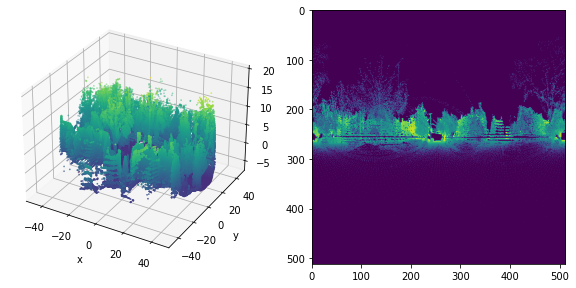

In [2]:
# Convert lidar point cloud to top sherical projection
lidar_to_sph = lidar_trans(
    top_size=(512, 512),
    sph_size=(512, 512),
    max_dis=50,
    fov_range=(-90, 90),
)  # for lidar projections

# load data
pcd = pitts_loader[41]['pcd'] # {'pcd': pcd}
sph_img = lidar_to_sph.sph_projection(pcd)  # get spherical projection
sph_img = (sph_img * 255).astype(np.uint8)

# show results
fig = plt.figure(figsize=(10, 5))
ax_pc = fig.add_subplot(121, projection='3d')
ax_img = fig.add_subplot(122)
#
ax_pc.scatter(
    pcd[:, 0], pcd[:, 1], pcd[:, 2], c=pcd[:, 2], s=3, linewidths=0,
)
ax_pc.set_xlabel('x')
ax_pc.set_ylabel('y')
ax_pc.set_xlim(-50.0, 50.0)
ax_pc.set_ylim(-50.0, 50.0)
ax_img.imshow(sph_img)
plt.show()

## Visiualize the trajectory

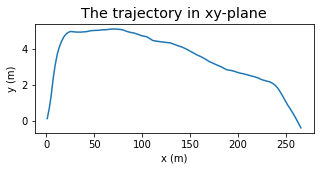

In [3]:
traj_xyz = [pitts_loader.get_translation(idx) for idx in range(len(pitts_loader))]
traj_xyz = np.vstack(traj_xyz)

# plot result
fig, ax = plt.subplots(1, 1, figsize=(5, 2))
plt.rcParams['font.size'] = '12'
plt.plot(traj_xyz[:, 0], traj_xyz[:, 1])
plt.title('The trajectory in xy-plane')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

## Evaluation Testing

comp. fea.: 100%|██████████| 100/100 [00:05<00:00, 17.08it/s]


Top 1 recall 47.96%
Top 5 recall 85.71%


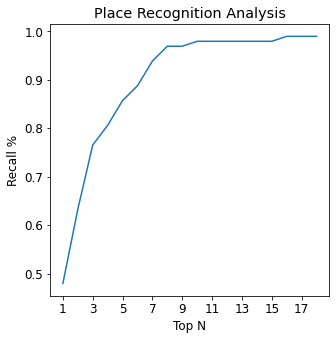

In [4]:
# * Point cloud conversion and feature extractor
lidar_to_sph = lidar_trans(
    top_size=(512, 512),
    sph_size=(512, 512),
    max_dis=50,
    fov_range=(-90, 90),
)  # for lidar projections
hog_fea = HogFeature()

# feature extraction
feature_ref = []
feature_test = []
for idx in tqdm(range(len(pitts_loader)), desc='comp. fea.'):
    pcd_ref = pitts_loader[idx]['pcd']
    pcd_test = pcd_ref @ np.array(
        [[0.866, 0.5, 0], [-0.5, 0.866, 0], [0, 0, 1]]
    )  # rotate pi/6 around z-axis
    
    sph_img = lidar_to_sph.sph_projection(pcd_ref)  # get spherical projection
    sph_img = (sph_img * 255).astype(np.uint8)
    feature_ref.append(hog_fea.infer_data(sph_img))  # get HOG feature

    sph_img = lidar_to_sph.sph_projection(pcd_test)  # get spherical projection
    sph_img = (sph_img * 255).astype(np.uint8)
    feature_test.append(hog_fea.infer_data(sph_img))  # get HOG feature
    
# evaluate recall
feature_ref = np.array(feature_ref)
feature_test = np.array(feature_test)
topN_recall, one_percent_recall = get_recall(
    feature_ref, feature_test, true_threshold=1, num_neighbors=18
)

# plot result
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.rcParams['font.size'] = '12'
plt.plot(np.arange(1, len(topN_recall) + 1), topN_recall)
plt.xticks(np.arange(1, len(topN_recall), 2))
plt.xlabel('Top N')
plt.ylabel('Recall %')
plt.title('Place Recognition Analysis')

print("Top 1 recall {:.2%}".format(topN_recall[0]))
print("Top 5 recall {:.2%}".format(topN_recall[4]))